In [1]:
import random
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi
import math
from scipy import stats

n = 10_000 # размер выборки
z = 1.96  # квантиль для доверительного интервала 95%

In [2]:
# практическое МО (ср. арифм.)
def MX_practical(sample):
    return sum(sample) / len(sample)

In [3]:
# практическая Дисперсия
# с поправкой (n-1, а не n) на смещение возникающее при использовании выборочного среднего вместо истинного среднего ГС
def DX_practical(sample):
    mx = MX_practical(sample)
    return sum((x_i - mx) ** 2 for x_i in sample) / (len(sample) - 1)

In [4]:
def MX_theory(f):
    x = sp.symbols('x')
    return sp.integrate(x * f, (x, 0, 1))

In [5]:
def DX_theory(f):
    x = sp.symbols('x')
    return float(sp.integrate(x ** 2 * f, (x, 0, 1))) - MX_theory(f) ** 2

In [6]:
def CI_MX(sample):
    mx = MX_practical(sample)
    dx = DX_practical(sample)
    delta = z * np.sqrt(dx) / np.sqrt(n)
    
    return mx - delta, mx + delta

In [7]:
def CI_DX(sample, confidence_level):
    dx_practical = DX_practical(sample)
    
    alpha1 = 1 - confidence_level / 2
    alpha2 = confidence_level / 2
    
    chi1 = chi.ppf(alpha1, n - 1)
    chi2 = chi.ppf(alpha2, n - 1)
    
    return (n - 1) * dx_practical / (chi1 ** 2), (n - 1) * dx_practical / (chi2 ** 2)


In [8]:
def generate_numbers(f, y):
    result = []
    for i in range(n):
        number = random.random()
        result.append(float(f.subs(y, number)))
    return result


In [9]:
def solve():
    x, y = sp.symbols('x,y')
    
    f = x ** 2
    rev_f = sp.solve(sp.Eq(y, f), x)[0]
   
    sample = generate_numbers(rev_f, y)
    
    df = sp.diff(f, x)

    mx_theory = MX_theory(df)
    dx_theory = DX_theory(df)
    
    mx_practical = MX_practical(sample)
    dx_practical = DX_practical(sample)
    
    ci_mx = CI_MX(sample)
    ci_dx = CI_DX(sample, 0.95)
	  
    statistic, p_value = stats.kstest(sample, lambda x: x)

    if p_value < 0.05:
        print("Rejected")

    plt.hist(sample, bins=50, color='brown')
    plt.xlabel("values")
    plt.ylabel("frequency")
    plt.show()
    
    print(f"{'Metric':<25} {'Value':<30}")
    print("=" * 48)

	# Print the values in a formatted table
    print(f"{'MX_theory':<25} {mx_theory:.8f} ")
    print(f"{'MX_practical':<25} {mx_practical:.8f} ")
    print(f"{'CI_MX':<25} ({float(ci_mx[0]):.8f}, {float(ci_mx[1]):.8f})")
    print(f"{'DX_theory':<25} {dx_theory:.8f} ")
    print(f"{'DX_practical':<25} {dx_practical:.8f} ")
    print(f"{'CI_DX':<25} ({float(ci_dx[0]):.8f}, {float(ci_dx[1]):.8f})")


-sqrt(y)
Rejected


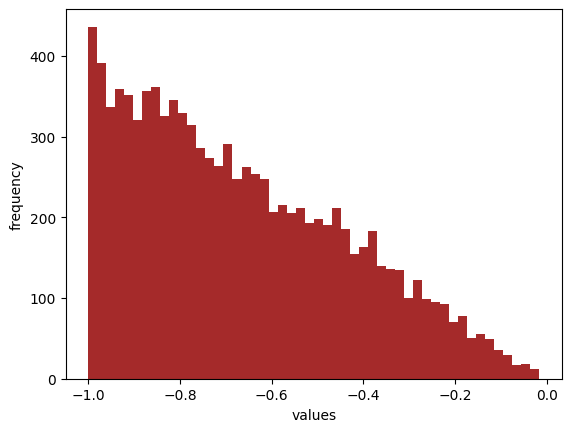

Metric                    Value                         
MX_theory                 0.66666667 
MX_practical              -0.66859382 
CI_MX                     (-0.67318961, -0.66399802)
DX_theory                 0.05555556 
DX_practical              0.05498057 
CI_DX                     (0.05493551, 0.05503303)


In [10]:
solve()

In [11]:
def MX_pascal(x, p):
    return x * (1 - p) / p

In [12]:
def DX_pascal(x, p):
    return x * (1 - p) / (p ** 2)

In [13]:
def negative_binomal(r, p, size):
    samples = []
    for _ in range(size):
        successes = 0
        failures = 0
        while successes < r:
            if np.random.rand() < p:
                successes += 1
            else:
                failures += 1
        samples.append(failures)
    
    return np.array(samples)

In [14]:
from scipy.stats import chisquare, nbinom

def check_pascal_distribution(sample, r, p, alpha=0.05):
    
    # Максимальное количество неудач в выборке
    max_value = np.max(sample)
    
    # Частоты появления каждого значения в выборке
    observed_freq, bin_edges = np.histogram(sample, bins=range(max_value + 2), density=False)
    
    # Теоретические вероятности распределения Паскаля (отрицательного биномиального)
    x_values = np.arange(0, max_value + 1)
    expected_prob = nbinom.pmf(x_values, r, p)
    
    # Теоретические частоты
    expected_freq = expected_prob * len(sample)
    
    # Нормализация частот
    observed_freq = observed_freq / np.sum(observed_freq)
    expected_freq = expected_freq / np.sum(expected_freq)

    # Приводим частоты к одинаковому масштабу
    observed_freq *= len(sample)
    expected_freq *= len(sample)

    # Удаляем нулевые теоретические частоты (для которых вероятность ≈ 0)
    non_zero_mask = expected_freq > 0
    observed_freq = observed_freq[non_zero_mask]
    expected_freq = expected_freq[non_zero_mask]
    
    # Применяем критерий χ²
    chi2_stat, p_value = chisquare(f_obs=observed_freq, f_exp=expected_freq)
    
    # Проверка гипотезы
    if p_value > alpha:
        return True
    else:
        return False

In [15]:
from scipy.stats import nbinom

def solve(n, p, x):
    # Расчет практ. негативного биномиального распределения
    neg_bin_practical = negative_binomal(x, p, n)
    
    # Расчет теорет. негативного биномиального распределения
    neg_bin_theory = nbinom.rvs(x, p, size=n)
    
    mx_theory = MX_pascal(x, p)
    dx_theory = DX_pascal(x, p)
    
    mx_practical = MX_practical(neg_bin_practical)
    dx_practical = DX_practical(neg_bin_practical)
    
    # Интервальные оценки
    ci_mx = CI_MX(neg_bin_practical)
    ci_dx = CI_DX(neg_bin_practical, 0.95)
    
    res = check_pascal_distribution(neg_bin_theory, x, p)
    
    if res == False:
        print('Rejected')
    
    plt.hist(neg_bin_practical, bins=range(min(neg_bin_practical), max(neg_bin_practical)), color='brown', edgecolor='black', density=True)
    plt.xlabel('Количество неудач')
    plt.ylabel('Вероятность')
    
    plt.show()
    
    print(f"{'Metric':<25} {'Value':<30}")
    print("=" * 48)

	# Print the values in a formatted table
    print(f"{'MX_theory':<25} {mx_theory:.8f} ")
    print(f"{'MX_practical':<25} {mx_practical:.8f} ")
    print(f"{'CI_MX':<25} ({float(ci_mx[0]):.8f}, {float(ci_mx[1]):.8f})")
    print(f"{'DX_theory':<25} {dx_theory:.8f} ")
    print(f"{'DX_practical':<25} {dx_practical:.8f} ")
    print(f"{'CI_DX':<25} ({float(ci_dx[0]):.8f}, {float(ci_dx[1]):.8f})")


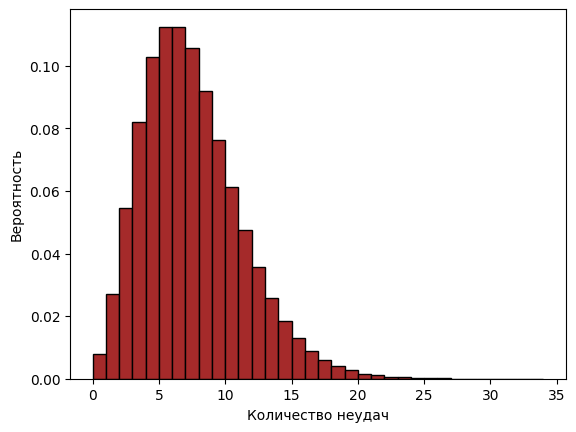

Metric                    Value                         
MX_theory                 7.00000000 
MX_practical              7.00082000 
CI_MX                     (6.92760793, 7.07403207)
DX_theory                 14.00000000 
DX_practical              13.95253928 
CI_DX                     (13.94110190, 13.96585192)


In [16]:
solve(1000000, 0.5, 7)